# COVID-19

Interpretable Machine Learning course homework no. 1\
Tymoteusz Makowski

[Data source](https://docs.google.com/spreadsheets/d/1itaohdPiAeniCXNlntNztZ_oRvjh0HsGuJXUJWET008/)

## Imports

In [1]:
import pandas as pd
import numpy as np
import shap

from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation

In [2]:
cols = [
    "age",
    "sex",
    "country",
    "date_onset_symptoms",
    "date_admission_hospital",
    "date_confirmation",
    "symptoms",
    "chronic_disease",
    "outcome",
    "date_death_or_discharge"
]

data_raw = pd.read_csv("data/covid19.csv", usecols=cols)
print(data_raw.shape)
data_raw.head(3)

(21241, 10)


,age,sex,country,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,chronic_disease,outcome,date_death_or_discharge
0,30,male,China,18.01.2020,20.01.2020,22.01.2020,NaN,NaN,NaN,NaN
1,47,male,China,10.01.2020,21.01.2020,23.01.2020,NaN,NaN,NaN,NaN
2,49,male,China,15.01.2020,20.01.2020,23.01.2020,NaN,NaN,NaN,NaN


# Data preparation

### Symptoms

In [3]:
symptoms_list = []
for symp in data_raw.symptoms:
    if not pd.isna(symp):
        symptoms_list += [s.strip() for s in symp.split(",")]
        
symptoms_raw = pd.Series(symptoms_list).map(lambda x: x.lower())
symptoms_counts = symptoms_raw.reset_index().rename(columns={0: "symptom"}).groupby("symptom").count().reset_index().rename(columns={"index": "cnt"})
signif_counts = symptoms_counts.query("cnt > 4").reset_index(drop=True)

for i in range(signif_counts.shape[0]):
    row = signif_counts.iloc[i, :]
    print("% 4d | %s" % (row.cnt, row.symptom))

   7 | asymptomatic
  10 | bone pain
   5 | chest tightness
  19 | chills
 184 | cough
   8 | coughing
   6 | diarrhea
   6 | discomfort
   8 | dyspnea
  19 | fatigue
 326 | fever
   6 | fever (38 ¬∞ c)
  17 | headache
   6 | joint pain
  13 | malaise
  10 | mild
   5 | muscular soreness
   6 | myalgia
   7 | nausea
   5 | phlegm
  16 | pneumonia
  19 | pneumonitis
  15 | runny nose
  10 | shortness of breath
   7 | sneezing
  33 | sore throat
   7 | sputum
   7 | weakness


In [4]:
# Greater than 2 cases.
# signif_symptoms_list = [
#     "abdominal pain", "acute respiratory viral infection", "anorexia", "asymptomatic", "body aches", "bone pain",
#     "breathing difficulty", "chest distress", "chest pain", "chest tightness", "chills", "cough", "diarrhea",
#     "difficulty breathing", "discomfort", "dyspnea", "expectoration", "fatigue", "fever", "headache", "joint pain",
#     "malaise", "muscle aches", "muscle soreness", "muscular soreness", "myalgia", "nasal congestion", "nausea",
#     "pharyngeal discomfort", "phlegm", "pneumonia", "pneumonitis", "respiratory symptoms", "rhinorrhea",
#     "runny nose", "shortness of breath", "sneezing", "sore muscle", "sore throat", "sputum", "vomiting"
# ]

# Greater than 4 cases.
signif_symptoms_list = [
    "asymptomatic", "bone pain", "chest tightness", "chills", "cough", "coughing", "diarrhea", "discomfort", "dyspnea",
    "fatigue", "fever", "headache", "joint pain", "malaise", "myalgia", "nausea", "phlegm", "pneumonia", "pneumonitis",
    "runny nose", "shortness of breath", "sneezing", "sore throat", "sputum"
]

signif_symptoms = dict(
    [("MuscleSoreness", "soreness"), ("Weakness", "weak")] +\
    [(s.title().replace(" ", ""), s) for s in signif_symptoms_list]
)

###  Utility functions

In [5]:
def map_outcome(x):
    if pd.isna(x):
        return 0
    return int(x in ["died", "death"])


def map_age(x):
    try:
        x = float(x)
    except ValueError:
        if x[0] == x[-2] and x[1] == "0" and x[-1] == "9":
            x = int(x[:2])
        else:
            return np.nan
        
    return x // 10


def map_sex(x):
    if pd.isna(x):
        return np.nan
    
    return int(x == "male")
    
    
def days_diff(x, y, date_format="%d.%m.%Y"):
    try:
        x = dt.strptime(x, date_format)
        y = dt.strptime(y, date_format)
    except:
        return np.nan
    
    return (x - y).days

###  Converting data

In [6]:
data = pd.DataFrame(columns=[
    "HasDied",
    "Age",
    "Sex",
    "Country",
    "DaysInHospital",
    "DaysBeforeHospitalization",
    "DaysBeforeConfirmation"
])

country_dict = dict([(c, np.nan if pd.isna(c) else i) for i, c in enumerate(data_raw.country.unique())])

for i in range(data_raw.shape[0]):
    d = {}
    row = data_raw.loc[i, :]
    
    d["HasDied"] = map_outcome(row.outcome)
    d["Age"] = map_age(row.age) # Age i: corresponds to (10 * i, 10 * (i + 1) - 1)
    d["Sex"] = map_sex(row.sex) # 1 - man, 0 - woman
    d["Country"] = country_dict.get(row.country)
    d["DaysInHospital"] = days_diff(row.date_death_or_discharge, row.date_admission_hospital)
    d["DaysBeforeHospitalization"] = days_diff(row.date_admission_hospital, row.date_onset_symptoms)
    d["DaysBeforeConfirmation"] = days_diff(row.date_confirmation, row.date_onset_symptoms)
    d["DaysAfterConfirmation"] = days_diff(row.date_death_or_discharge, row.date_confirmation) # Days as confirmend affected
    
    # Symptoms
    for k, v in signif_symptoms.items():
        d[k] = np.nan if pd.isna(row.symptoms) else int(row.symptoms.find(v) != -1)
    
    data = data.append(d, ignore_index=True)

data.head(5)

,HasDied,Age,Sex,Country,DaysInHospital,DaysBeforeHospitalization,DaysBeforeConfirmation,Asymptomatic,BonePain,ChestTightness,...,Nausea,Phlegm,Pneumonia,Pneumonitis,RunnyNose,ShortnessOfBreath,Sneezing,SoreThroat,Sputum,Weakness
0,0.0,3.0,1.0,0.0,NaN,2.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,4.0,1.0,0.0,NaN,11.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,4.0,1.0,0.0,NaN,5.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,4.0,0.0,0.0,NaN,3.0,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,5.0,0.0,0.0,NaN,11.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Splitting the data

In [7]:
# Requiring at least two non-missing features.
feature_names = data.columns[1:]

# Full dataset.
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    np.array(data.dropna(thresh=3).iloc[:, 1:]),
    np.array(data.dropna(thresh=3).iloc[:, 0]),
    test_size=0.3,
    random_state=58
)

# Only records with outcome value not missing.
has_outcome = ~data_raw.outcome.isna()
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    np.array(data[has_outcome].dropna(thresh=3).iloc[:, 1:]),
    np.array(data[has_outcome].dropna(thresh=3).iloc[:, 0]),
    test_size=0.3,
    random_state=58
)

# Dataset without symptoms.
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    np.array(data.dropna(thresh=3).iloc[:, 1:7]),
    np.array(data.dropna(thresh=3).iloc[:, 0]),
    test_size=0.3,
    random_state=58
)

# Modelling

## Full dataset

In [8]:
model1 = CatBoostClassifier(random_seed=58)
model1.fit(X_train1, y_train1, verbose=False)

In [9]:
# The classes are extremely unbalanced, hence its a good thing if the classfier predicted literally anything to be in class 1.
pred_labels1 = model1.predict(X_test1)
(pred_labels1 == 1).sum(), (y_test1 == 1).sum()

(2, 7)

In [10]:
# Accuracy
(pred_labels1 == y_test1).sum() / len(y_test1)

0.9850498338870431

In [11]:
# F1 score
f1_score(pred_labels1, y_test1)

0.0

## Limited dataset

In [12]:
model2 = CatBoostClassifier(random_seed=58)
model2.fit(X_train2, y_train2, verbose=False)

In [13]:
# The classes are extremely unbalanced, hence its a good thing if the classfier predicted literally anything to be in class 1.
pred_labels2 = model2.predict(X_test2)
(pred_labels2 == 1).sum(), (y_test2 == 1).sum()

(4, 3)

In [14]:
# Accuracy
(pred_labels2 == y_test2).sum() / len(y_test2)

0.9791666666666666

In [15]:
# F1 score
f1_score(pred_labels2, y_test2)

0.8571428571428571

## Dataset without symptoms

In [16]:
model3 = CatBoostClassifier(random_seed=58)
model3.fit(X_train3, y_train3, verbose=False)

In [17]:
# The classes are extremely unbalanced, hence its a good thing if the classfier predicted literally anything to be in class 1.
pred_labels3 = model3.predict(X_test3)
(pred_labels3 == 1).sum(), (y_test3 == 1).sum()

(0, 7)

In [18]:
# Accuracy
(pred_labels3 == y_test3).sum() / len(y_test3)

0.9883720930232558

In [19]:
# F1 score
f1_score(pred_labels3, y_test3)

0.0

# Explaining

## Full dataset

In [20]:
shap_explainer1 = shap.TreeExplainer(model1, feature_perturbation="tree_path_dependent")
shap_values1 = shap_explainer1.shap_values(X_train1)

### SHAP summary

With the full dataset the information is quite skewed, most likely to the huge class inbalance.

As we can see on the plot below the highest importance was assigned to the `Country` variable with `Age` being second. The `Country` information cannot be easily decoded on the dataset level however, the `Age` provides information than younger people are more likely to die from COVID-19. Additonally, the people who have any symptoms tend to be less likely to die from COVID-19... which does not make much sense to me.

The more interesting results are the ones with `Sex`, `DaysBeforeConfirmation` and `DaysBeforeHospitalization`. The first one, `Sex`, suggests than women (coded to 0) are more likely to die. Moreover, the longer the wait since first symptoms before a confirmation that the patient in fact has the COVID-19 the higher the chance of death. Finally, lower time between onset symptoms and hospitalization the higher chance of survival however, not by a huge margin.

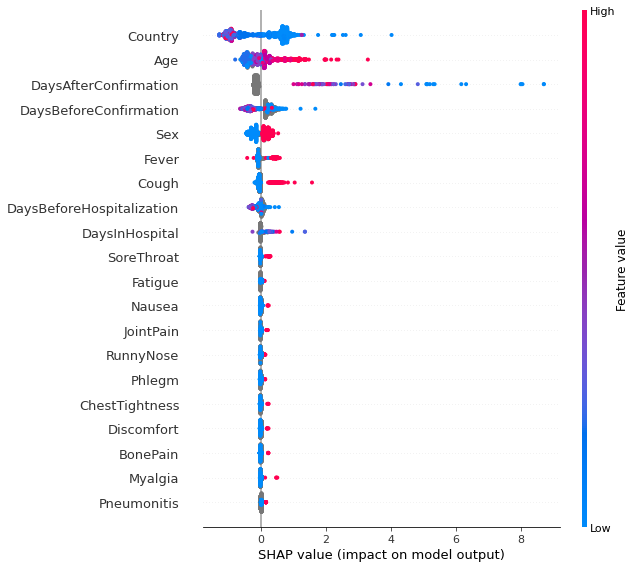

In [21]:
shap.summary_plot(shap_values1, X_train1, feature_names=feature_names)

### Example false negative

The plot below shows an example of false negative. As we can se most of the information which has positive impact on survivability is based purely on one feature and missing values in two other. That is due to the data having lots of missing values.

In [23]:
np.where(np.logical_and(pred_labels1 == 0, y_test1 == 1))

(array([304, 394, 441, 446, 454, 490, 501], dtype=int64),)

In [ ]:
shap.waterfall_plot(shap_explainer1.expected_value, shap_values1[446, :], feature_names=feature_names, features=X_test1[446, :])

## Limited dataset

In [28]:
shap_explainer2 = shap.TreeExplainer(model2, feature_perturbation="tree_path_dependent")
shap_values2 = shap_explainer2.shap_values(X_train2)

### SHAP summary

In comparison to the full dataset summary the `Country` variable's distribution shifted towards negative impact on model output. Additionally, `DaysInHospital` variable became more important stating that in general the longer hospitalization is the worse survival odds are.

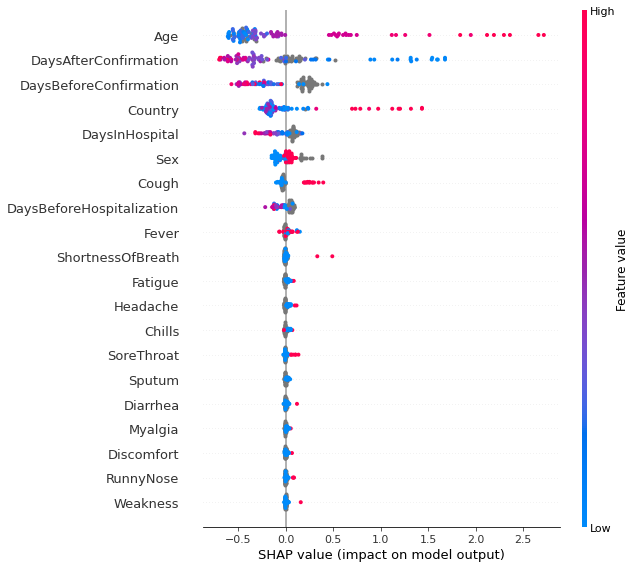

In [29]:
shap.summary_plot(shap_values2, X_train2, feature_names=feature_names)

### Example true positive

The record represent an older man (70-79 age) who lived in Italy. There was no information how much time passed since onset symptoms to either confirmation or hospitalization. This can mean start of symptoms was not determined before the patient died, leaving the data missing.

In [30]:
np.where(np.logical_and(pred_labels2 == 1, y_test2 == 1))

(array([27, 31, 43], dtype=int64),)

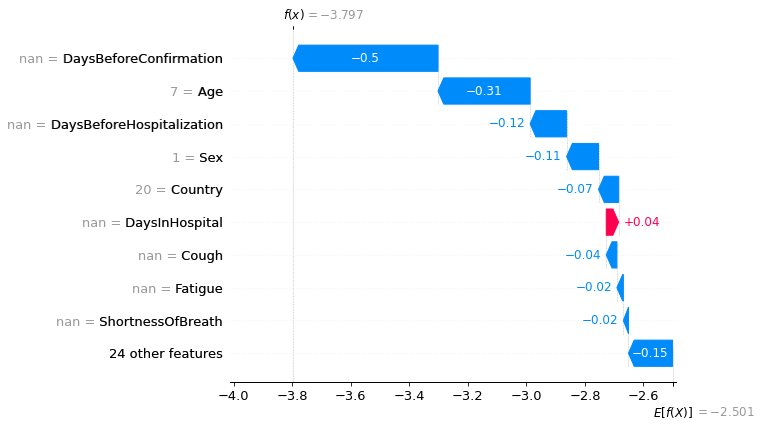

In [31]:
shap.waterfall_plot(shap_explainer2.expected_value, shap_values2[43, :], feature_names=feature_names, features=X_test2[43,:])

### Example false positive

Again information for this record is mostly based on missing data. Additionally, the fact that `DaysAfterConfirmation` is equal to 1 greatly skewes prediction towards a death. That is due to the very short period between disease confirmation and a cure / death. With value this low model most likely assumes its a death since scenario where person is cured one day after confirmation seems unlikely.

In [32]:
np.where(np.logical_and(pred_labels2 == 1, y_test2 == 0))

(array([16], dtype=int64),)

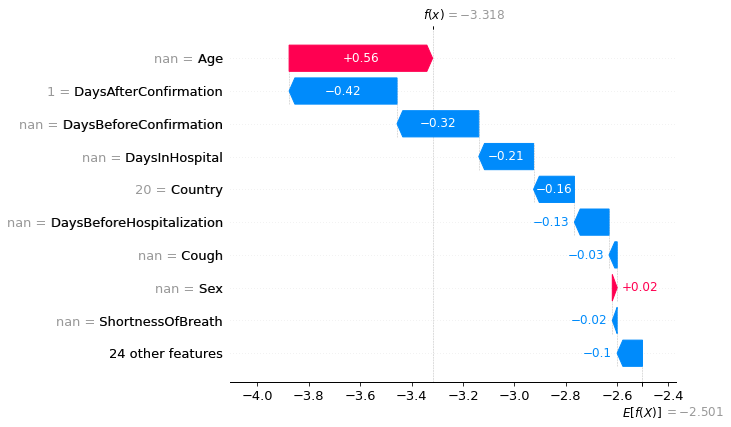

In [33]:
shap.waterfall_plot(shap_explainer2.expected_value, shap_values2[16, :], feature_names=feature_names, features=X_test2[16,:])

## Dataset without symptoms

In [34]:
shap_explainer3 = shap.TreeExplainer(model3, feature_perturbation="tree_path_dependent")
shap_values3 = shap_explainer3.shap_values(X_train3)

### SHAP summary

As seen on the summary plot below, this model is very randomized with very few deciding factors, i.e. almost every variable has a balanced distribution.

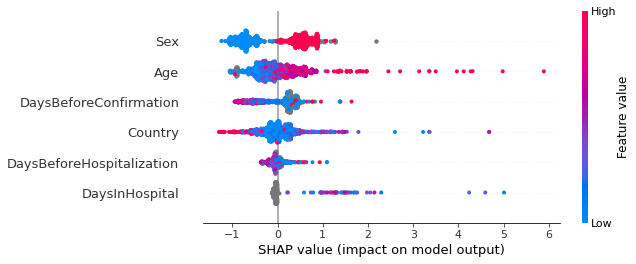

In [35]:
shap.summary_plot(shap_values3, X_train3, feature_names=feature_names)

# Summary

The [source dataset](https://docs.google.com/spreadsheets/d/1itaohdPiAeniCXNlntNztZ_oRvjh0HsGuJXUJWET008/) has very unclean data with huge amount of missing or imprecise data. Additionally, only about 200 records have `outcome` value provided out of which only 19 is class 1 - death. This raises a dilemma whether we should limit the dataset to those 200 records or go with full dataset and fill any missing value with class 0.

I have tried both approaches with data to the modelling as well as disabling symptoms for the full dataset. Out of the three only the limited dataset approach yielded reasonable metrics (`0.88` F1-score). Overall the symptoms variables seemd to have exactly opposite effect that we would expect, i.e. if someone had cough and fever then they would be less likely to die. The variables which can be reasonably explained are `DaysBeforeConfirmation` and `DaysInHospital` - both of them seem to be correlated with mortality. The more time it took to confirm that it is COVID-19 or the more time a patient spends in hospital the less likely they are to survive.